In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from feature_engine.outliers import Winsorizer
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from feature_engine.outliers import Winsorizer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn import set_config, get_config
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from pprint import pprint
from collections import defaultdict
import tools
from sklearn.ensemble import GradientBoostingRegressor

set_config(transform_output="pandas")
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit, plot_splits, print_cv_info, print_split_info


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.3f}'.format
import warnings; warnings.filterwarnings('ignore')


In [2]:
old_train = pd.read_csv('./data/raw/godaddy-microbusiness-density-forecasting/train.csv')
new_train = pd.read_csv('./data/raw/godaddy-microbusiness-density-forecasting_new/revealed_test.csv')

old_test = pd.read_csv('./data/raw/godaddy-microbusiness-density-forecasting/test.csv')
sample_submission = pd.read_csv('./data/raw/godaddy-microbusiness-density-forecasting/sample_submission.csv')

train = pd.concat((old_train, new_train))
test = old_test[~old_test['first_day_of_month'].isin(new_train['first_day_of_month'])]

train['is_test'] = 0 ; test['is_test'] = 1

data = pd.concat((
        train,
        test)
        )\
    .reset_index(drop=True)\
    .assign(
        cfips = lambda df: df['cfips'].astype(str).str.zfill(5),
        date = lambda df: pd.to_datetime(df["first_day_of_month"]),
        # mdensity_t0 = lambda df: df['microbusiness_density'],
        # active_t0 = lambda df: df['active'],
        )\
    .sort_values(['cfips','date'], ascending=True)\
    .assign(
    
        state_i = lambda df: df['cfips'].apply(lambda x: x[:2]),
        county_i = lambda df: df['cfips'].apply(lambda x: x[2:]),
        
        year = lambda df: df['date'].dt.year,
        date = lambda df: df["date"].dt.date,
        # month = lambda df: df['date'].dt.month,

        dcount = lambda df: df.groupby('cfips')['row_id'].cumcount(),
        
        # active_lag1 = lambda df: df.groupby('cfips')['active'].shift(1),
        # active_lag2 = lambda df: df.groupby('cfips')['active_t0'].shift(2),
        # active_lag3 = lambda df: df.groupby('cfips')['active_t0'].shift(3),
        active_lag_1 = lambda df: df.groupby('cfips')['active'].shift(1),
        active_lag_2 = lambda df: df.groupby('cfips')['active'].shift(2),
        active_lag_3 = lambda df: df.groupby('cfips')['active'].shift(3),
        active_lag_4 = lambda df: df.groupby('cfips')['active'].shift(4),

        target_0 = lambda df: np.nan_to_num(df['active']/df.groupby('cfips')['active'].shift(1)-1, posinf=10),
        target_1 = lambda df: np.nan_to_num(df['active']/df.groupby('cfips')['active'].shift(2)-1, posinf=10),
        target_2 = lambda df: np.nan_to_num(df['active']/df.groupby('cfips')['active'].shift(3)-1, posinf=10),
        # target_0 = lambda df: np.nan_to_num(df['active'], posinf=10),
        # target_1 = lambda df: np.nan_to_num(df['active'], posinf=10),
        # target_2 = lambda df: np.nan_to_num(df['active'], posinf=10),

    )\
    .drop(['county','state'], axis='columns')
# .sort_index(ascending=True)

assert all(data.groupby('cfips')['county_i'].nunique() == 1)
assert all(data.groupby('cfips')['state_i'].nunique() == 1)
assert data['cfips'].nunique() == 3135 # there are 3135 county,state tuples
assert data['dcount'].nunique() == 47 # there are 47 series for each county state tuple
assert data.query('is_test==0')['dcount'].nunique() == 41 # there are 41 series in the train set. 
assert data.query('is_test==1')['dcount'].nunique() == 6  # there are 6 series in the test set. 

#The private leaderboard will include 03-2023, 04-2023, 05-2023
#The public leaderboard includes the first month 11-2022. Probably it will be updated later as 12-2022,01-2023 and 02-2023
#The LB is updated as 01-2023

# adding census data
data_census = []
for year in range(2017,2022):
    COLS = ['GEO_ID','NAME','S0101_C01_026E']
    data_census_i = pd.read_csv(f'./data/raw/census_data_1/ACSST5Y{year}.S0101-Data.csv',usecols=COLS)
    data_census_i = data_census_i.iloc[1:]
    data_census_i['population'] = data_census_i['S0101_C01_026E'].astype('int')


    data_census_i['cfips'] = data_census_i.GEO_ID.apply(lambda x: f"{int(x.split('US')[-1]):05}" )
    data_census_i['year'] = year+2
    data_census.append(data_census_i[['cfips','year','population']])

data_census = pd.concat((data_census),axis='rows')

data = data.merge(data_census, on=['cfips','year'], how='left')

In [3]:
# data.query('cfips=="46127"')['microbusiness_density'].plot()
# data.query('cfips=="46127"')['active'].plot()

# Sample Data

In [4]:
# PARAMETERS
n_SPLITS = 5 
n_TRAIN_TRAIN_SIZE = 6
n_TRAIN_PERIOD = n_TRAIN_TRAIN_SIZE + 3 + n_SPLITS - 1 


TEST_DATES = list(np.sort(data.query('is_test==1')['date'].unique())[:3])
TEST_PERIOD = list(np.sort(data.query('is_test==1')['dcount'].unique())[:3])

TRAIN_PERIOD = list(np.sort(data.query('is_test==0')['dcount'].unique())[-n_TRAIN_PERIOD:])
TRAIN_DATES = list(np.sort(data.query('is_test==0')['date'].unique())[-n_TRAIN_PERIOD:])

LEAKAGE = ['microbusiness_density','active']
TARGETS = ['target_0', 'target_1', 'target_2']
FEATURES = ['population']


In [5]:
# data[data['dcount'].isin(TEST_PERIOD)].head()
# sample = data[data.cfips.isin(['01001'])] # sample = data[data.cfips.isin(['01001','56045'])]

sample = data.copy()
sample.loc[sample.is_test==1,TARGETS]  = np.nan
# sample = sample.set_index(['date','cfips']).sort_index().loc[TRAIN_DATES+TEST_DATES]

# sample = sample.assign(
#     [lambda df: df.groupby('cfips')[TARGETS[0]].shift(i+1) for i in range(LAGS) ]
#     )

sample = sample.sort_values(['cfips','date'])

LAGS = 4
for i in range(1, LAGS+1):
    lag_col = f'target_lag{i}'
    sample[lag_col] = sample.groupby('cfips')[TARGETS[0]].shift(i)  

sample = sample[sample['date'].isin(TRAIN_DATES + TEST_DATES)]
sample = sample.sort_values('dcount')
# sample = sample[ ['cfips','date','dcount','target_lag1','target_lag2','target_lag3'] +TARGETS + FEATURES+ LEAKAGE]
sample_train= sample.query("dcount in @TRAIN_PERIOD") ; sample_test= sample.query("dcount in @TEST_PERIOD")
train_X = sample_train.drop(TARGETS,axis='columns') ; train_y = sample_train[TARGETS]
test_X = sample_test.drop(TARGETS,axis='columns') ; test_y = sample_test[TARGETS]


In [6]:
# train_X['target_lag3'].values[:10]

In [7]:
# display(train_X.head() , train_y.head())

In [8]:
# from tools import BaseTransformer

# class SimpleFeatureEngineering(BaseTransformer):
#     def __init__(self, features):
#         self.features = features
	    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         X_transformed = X.copy()
#         # col1 = f'ratio_{self.features[0]}_{self.features[1]}'
#         # X_transformed[col1] = ((X_transformed[self.features[0]]/X_transformed[self.features[1]]) - 1).fillna(0)

        
#         # new_features = [col1,col2]
#         # return X_transformed[new_features]
#         return X_transformed[]

In [9]:
# test_X.head()

In [10]:
# SimpleFeatureEngineering([['target_lag1']]).transform(sample)

# Pipelining

In [11]:
lag=2
list_cols_model = [[f'target_lag{lag_i+model_i+1}' for lag_i in range(lag)] for model_i in range(3)]

dic_pipelines = {}
y_test_preds  = [] 

y_val_preds = defaultdict(list)
errors = defaultdict(list)


for model_i in range(3):

    train_y_i = train_y.iloc[:, model_i]
    
    cv_args = {"test_size": 1, "n_splits": n_SPLITS, "train_size": n_TRAIN_TRAIN_SIZE, 'gap_size': 0}
    
    cv = GroupTimeSeriesSplit(**cv_args)

    # # new_features = Pipeline([('select', SimpleFeatureEngineering(features=list_cols_model[model_i]))])
    # # print(list_cols_model[model_i])

    raw_features = Pipeline([('select', tools.ColumnSelector(features=list_cols_model[model_i]))])
    
    merge_features_numeric = FeatureUnion([
        # ('new_features', new_features),
        ('raw_features', raw_features)
    ])

    final_features_numeric = Pipeline([
                            ('merge_features',merge_features_numeric),
                            # ('remove_outliers', Winsorizer(capping_method='iqr', tail='both',fold=1)),
                            # ('standart_scaler', StandardScaler())
                            ]
                            )

    
    model = TransformedTargetRegressor(regressor=LinearRegression())
    # model = TransformedTargetRegressor(regressor=tools.LagModel(), transformer=None)
    
    
    model_pipeline = Pipeline([
        ("transform", final_features_numeric),
        ("model", model)
    ])

    dic_pipelines[f'pipeline_model_{model_i}'] = model_pipeline
    
    param_grid = {}
    grid = GridSearchCV(dic_pipelines[f'pipeline_model_{model_i}'], scoring=make_scorer(tools.SMAPE_1, greater_is_better=False), param_grid=param_grid, cv=cv)
    
    grid.fit(train_X, train_y_i, groups=train_X['dcount'])
    
    # print(grid.cv_results_)
    # print(grid.best_estimator_)
    
    # ## CHECK

    check_train_period = TRAIN_PERIOD[-1-n_TRAIN_TRAIN_SIZE: -1] 
    check_validation_period = [TRAIN_PERIOD[-1]]

    best_model = grid.best_estimator_
    check_train_index = train_X.query('dcount in @check_train_period').index
    best_model.fit(train_X.loc[check_train_index], train_y_i.loc[check_train_index])  
    
    val_index = train_X.query('dcount in @check_validation_period').index
    y_val_pred =  (best_model.predict(train_X.loc[val_index])+1)*train_X.loc[val_index,'active_lag_1']	
    y_val_preds[f'target_{model_i}'] = y_val_pred
    
    errors[f'error_{model_i}'] = tools.SMAPE_1(y_true= train_X.loc[val_index,'active'], y_pred=y_val_pred)

    # INFERENCE
    final_train_period = TRAIN_PERIOD[-n_TRAIN_TRAIN_SIZE:] 
    final_train_index = train_X.query('dcount in @final_train_period').index
    TEST_PERIOD_i = [TEST_PERIOD[model_i]]

    best_model.fit(train_X.loc[final_train_index], train_y_i.loc[final_train_index])
    y_test_preds.append(best_model.predict(test_X.query('dcount in @TEST_PERIOD_i')))

# # prepare test the output
test_X['ratio_pred'] = np.concatenate((y_test_preds))

# # prepare validation for error analysis
val_X = train_X.query('dcount in @check_validation_period')
y_val_preds =  pd.DataFrame(y_val_preds, index=val_X.index)
val_X = pd.concat((val_X, y_val_preds), axis=1)


In [12]:
errors

defaultdict(list,
            {'error_0': 1.8583042562020715,
             'error_1': 1.9768251706144178,
             'error_2': 2.1703587899037933})

In [13]:
test_X = test_X.sort_values(['cfips','first_day_of_month'])

In [14]:
test_X['benchmark'] = test_X.groupby('cfips').first()[['active_lag_1','active_lag_1','active_lag_1']].stack().values

In [15]:
for i,TEST_PERIOD_i in enumerate(TEST_PERIOD):
    test_index = test_X.query('dcount == @TEST_PERIOD_i').index 
    test_X.loc[test_index,'pred'] = (test_X.loc[test_index]['ratio_pred']+1)*test_X.loc[test_index][f'active_lag_{i+1}']


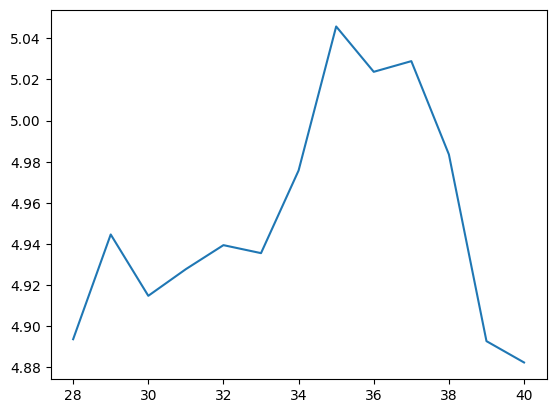

In [16]:
random_id = np.random.choice(train_X['cfips'])

plt.plot(train_X.query('cfips==@random_id')['dcount'],train_X.query('cfips==@random_id')['microbusiness_density'])
plt.plot(test_X.query('cfips==@random_id')['dcount'],test_X.query('cfips==@random_id')['microbusiness_density'])
# plt.plot(test_X.query('cfips==@random_id')['dcount'],test_X.query('cfips==@random_id')['benchmark'], '--')

In [725]:
test_X['final_pred'] = test_X['pred']
condition = test_X['population']<np.quantile(test_X['population'],q=.3)
test_X.loc[condition,'final_pred'] = test_X.loc[condition,'benchmark']

In [726]:
# # # Prepare submission file

# microbusiness_density = 100 * active / adult_population
# 100*data.head()['active'] / data.head()['population']
# test_X['microbusiness_density'] = 100 * test_X['active'] / test_X['population']

date_submission = '0903'
local_score = round(errors['error_0'],2)
model_name = 'ratio_regression_lag_1_2_with_.4_constant'

df_output = test_X.assign(
    microbusiness_density = lambda df: 100 * df['final_pred'] / df['population'],
    row_id = lambda df: df.apply(lambda df: "{}_{}".format(int(df['cfips']),df['date']), axis='columns'))[['row_id','microbusiness_density']]

submission = pd.concat((
    df_output,
    sample_submission[~sample_submission.row_id.isin(df_output.row_id)]))

submission.to_csv(f"data/{date_submission}_{model_name}_local_{local_score}.csv",index=None)


# ERROR ANALYSIS

In [651]:
# val_X['target_benchmark'] = val_X['active_lag1']
# val_X['error_0']= val_X[['active_t0','target_0']].apply(lambda x: tools.SMAPE_1(x[[0]],x[[1]]),axis=1)
# val_X['error_benchmark']= val_X[['active_t0','target_benchmark']].apply(lambda x: tools.SMAPE_1(x[[0]],x[[1]]),axis=1)
# val_X['error_1']= val_X[['active_t0','target_1']].apply(lambda x: tools.SMAPE_1(x[[0]],x[[1]]),axis=1)
# val_X['error_2']= val_X[['active_t0','target_2']].apply(lambda x: tools.SMAPE_1(x[[0]],x[[1]]),axis=1)



In [44]:
# df_errors = val_X.sort_values('error_0', ascending=False)
# df_errors['cum_error'] = df_errors['error_0'].expanding().mean()
# df_errors['cum_error_benchmark'] = df_errors['error_benchmark'].expanding().mean()
# # val_X

In [46]:
# df_errors['cum_error'].plot()
# df_errors['cum_error_benchmark'].plot()

In [47]:
# errors[errors['error_0']>20]


In [ ]:
# errors['c_population']=  pd.cut(np.log1p(errors['population']),5)
# errors['c_population'].value_counts()
# errors.groupby(['c_population'])['error_0'].describe()

,count,mean,std,min,25%,50%,75%,max
c_population,,,,,,,,
"(4.51, 6.793]",40.00,7.47,9.41,0.54,2.02,3.72,10.40,49.44
"(6.793, 9.064]",752.00,3.08,6.74,0.00,0.77,1.47,2.99,116.12
"(9.064, 11.335]",1782.00,1.63,6.09,0.00,0.31,0.72,1.43,121.50
"(11.335, 13.606]",517.00,0.78,2.08,0.00,0.18,0.39,0.69,37.89
"(13.606, 15.878]",44.00,0.50,0.48,0.02,0.18,0.39,0.60,2.07


In [ ]:
# errors = errors[errors['error_0']>1]

In [155]:
# plt.scatter( np.log1p(errors['population']), np.log1p(errors['error_0']))